In [5]:
# dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

engine = create_engine("sqlite:///hawaii.sqlite")

# Reflect Tables into SQLAlchemy ORM

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<AxesSubplot:xlabel='date'>

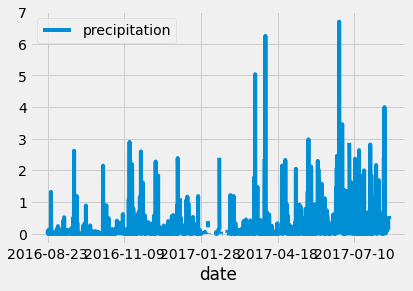

In [108]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# set up last bound of date we want info for, specify list to put the queried data in
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
results = []

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation']).set_index(df['date'])

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [41]:
# What are the most active stations?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.round(func.avg(Measurement.tobs), 2)) \
    .filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66)]

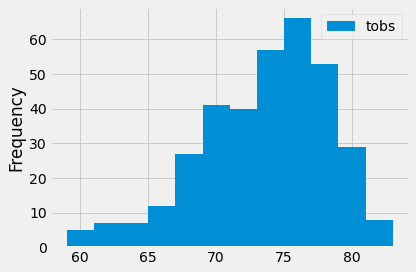

In [61]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.tobs) \
    .filter((Measurement.station == 'USC00519281') & (Measurement.date >= prev_year)).all()

temps_df = pd.DataFrame(temps, columns=['tobs'])

temps_df.plot.hist(bins = 12)
plt.tight_layout()


In [102]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):

    #get min, max, and avg temp by station
    temps = session.query(Measurement.station, func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs), 2), func.max(Measurement.tobs)) \
        .group_by(Measurement.station) \
        .filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()
    
    temps_df = pd.DataFrame(temps, columns=['Station', 'Min Temp', 'Avg Temp', 'Max Temp'])
    
    return (temps_df)

In [107]:
calc_temps('2016-05-15', '2017-05-15')

,Station,Min Temp,Avg Temp,Max Temp
0,USC00513117,61.0,73.28,79.0
1,USC00514830,63.0,76.81,83.0
2,USC00516128,58.0,71.63,82.0
3,USC00517948,62.0,74.77,82.0
4,USC00519281,59.0,73.20,82.0
5,USC00519397,60.0,74.87,82.0
6,USC00519523,60.0,76.75,84.0


# Challenge